# Advanced Latent Optimization Strategies

This notebook trains a small demo model on the sample polymer data (density target) and then explores `optimize_latent` strategies:
1. Data-driven initialization (seeds from descriptors)
2. Perturbation to escape local optima
3. Multi-restart for global search
4. Comparison of different starting strategies


In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    MLPEncoderConfig,
    RegressionTaskConfig,
    AutoEncoderTaskConfig,
    OptimizerConfig,
)

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Libraries loaded (device={device})")


✓ Libraries loaded (device=cpu)


## Train a quick model using sample polymer data

We load descriptors/targets from `samples/dynamic_task_suite_config.toml` paths, fit a small model on `density`, and reuse that model for latent optimization.


In [2]:
# If parquet support is missing, uncomment the next line in your environment:
# %pip install pandas pyarrow --quiet


Epoch 1: loss=0.3342
Epoch 2: loss=0.0484
Epoch 3: loss=0.0187
Epoch 4: loss=0.0099
Epoch 5: loss=0.0076
Epoch 6: loss=0.0064
Epoch 7: loss=0.0050
Epoch 8: loss=0.0052
Epoch 9: loss=0.0059
Epoch 10: loss=0.0041
Epoch 11: loss=0.0046
Epoch 12: loss=0.0046
Epoch 13: loss=0.0039
Epoch 14: loss=0.0044
Epoch 15: loss=0.0035
Epoch 16: loss=0.0032
Epoch 17: loss=0.0044
Epoch 18: loss=0.0048
Epoch 19: loss=0.0040
Epoch 20: loss=0.0038
Epoch 21: loss=0.0053
Epoch 22: loss=0.0035
Epoch 23: loss=0.0025
Epoch 24: loss=0.0033
Epoch 25: loss=0.0037
Epoch 26: loss=0.0037
Epoch 27: loss=0.0035
Epoch 28: loss=0.0041
Epoch 29: loss=0.0025
Epoch 30: loss=0.0028
Epoch 31: loss=0.0033
Epoch 32: loss=0.0032
Epoch 33: loss=0.0031
Epoch 34: loss=0.0021
Epoch 35: loss=0.0030
Epoch 36: loss=0.0037
Epoch 37: loss=0.0024
Epoch 38: loss=0.0033
Epoch 39: loss=0.0024
Epoch 40: loss=0.0022
Epoch 41: loss=0.0021
Epoch 42: loss=0.0028
Epoch 43: loss=0.0028
Epoch 44: loss=0.0024
Epoch 45: loss=0.0027
Epoch 46: loss=0.00

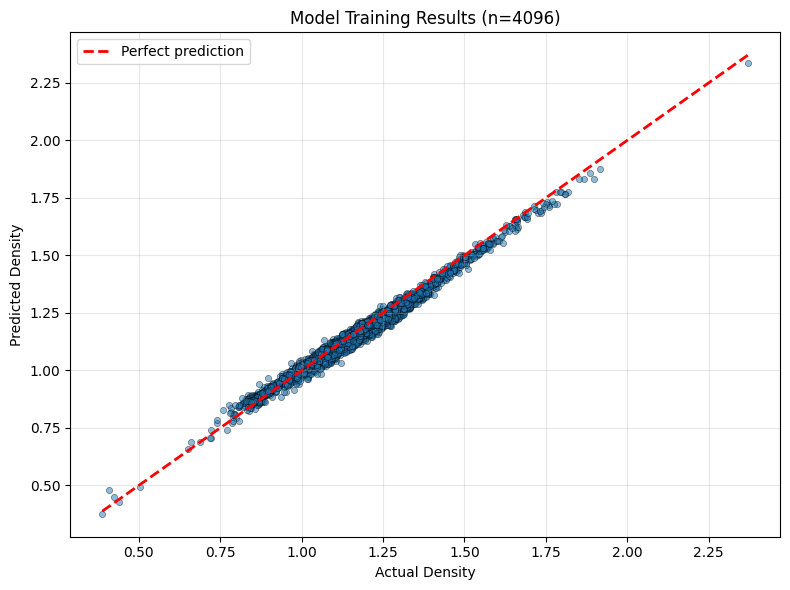


Training Set Metrics:
  MAE:  0.0230
  RMSE: 0.0273
  R²:   0.9754


In [3]:
from loguru import logger as fm_logger
fm_logger.disable("foundation_model")

descriptor_path = Path('../data/amorphous_polymer_FFDescriptor_20250730.parquet')
target_path = Path('../data/amorphous_polymer_non_PI_properties_20250730.parquet')
target_name = 'density'

descriptors = pd.read_parquet(descriptor_path)
properties = pd.read_parquet(target_path)[[target_name]]

# Merge and keep numeric descriptor columns
merged = descriptors.join(properties).dropna(subset=[target_name])
descriptor_cols = [c for c in descriptors.columns if pd.api.types.is_numeric_dtype(descriptors[c])]
X = torch.tensor(merged[descriptor_cols].values, dtype=torch.float32)
y = torch.tensor(merged[target_name].values, dtype=torch.float32).unsqueeze(1)

max_samples = 4096
if len(X) > max_samples:
    X = X[:max_samples]
    y = y[:max_samples]

X = X.to(device)
y = y.to(device)
input_dim = X.shape[1]
latent_dim = 128

encoder_config = MLPEncoderConfig(hidden_dims=[input_dim, 256, latent_dim], norm=True)
density_task = RegressionTaskConfig(
    name='density',
    data_column='density',
    dims=[latent_dim, 64, 1],
    norm=True,
)
ae_task = AutoEncoderTaskConfig(
    name='reconstruction',
    data_column='__autoencoder__',
    dims=[latent_dim, 256, input_dim],
    norm=True,
)

model = FlexibleMultiTaskModel(
    encoder_config=encoder_config,
    task_configs=[density_task, ae_task],
    shared_block_optimizer=OptimizerConfig(lr=5e-3),
).to(device)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
optim = torch.optim.Adam(model.parameters(), lr=5e-3)

model.train()
for epoch in range(200):
    total = 0.0
    for batch_x, batch_y in loader:
        optim.zero_grad()
        _, h = model.encoder(batch_x)
        pred = model.task_heads['density'](h)
        recon = model.task_heads['reconstruction'](h)
        loss = F.mse_loss(pred, batch_y) + F.mse_loss(recon, batch_x)
        loss.backward()
        optim.step()
        total += loss.item() * batch_x.size(0)
    print(f'Epoch {epoch+1}: loss={total / len(dataset):.4f}')

model.eval()
train_features = X
print(f'Training complete. Samples used: {len(dataset)}, input_dim={input_dim}')


# Scatter plot showing model predictions vs actual targets on training data
with torch.no_grad():
    preds = model(X)['density'].cpu().numpy()
targets = y.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(targets, preds, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual Density')
plt.ylabel('Predicted Density')
plt.title(f'Model Training Results (n={len(targets)})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print evaluation metrics
mae = np.abs(preds - targets).mean()
rmse = np.sqrt(((preds - targets) ** 2).mean())
r2 = 1 - ((preds - targets) ** 2).sum() / ((targets - targets.mean()) ** 2).sum()
print('\nTraining Set Metrics:')
print(f'  MAE:  {mae:.4f}')
print(f'  RMSE: {rmse:.4f}')
print(f'  R²:   {r2:.4f}')


## Strategy 1: Random Initialization (data-driven seed)

We start from a random seed in input space (same dimensionality as the descriptors).

Random Initialization Results:
  Initial score: 2.3365
  Optimized scores (per restart): [2.532176]
  Best improvement: +0.1957


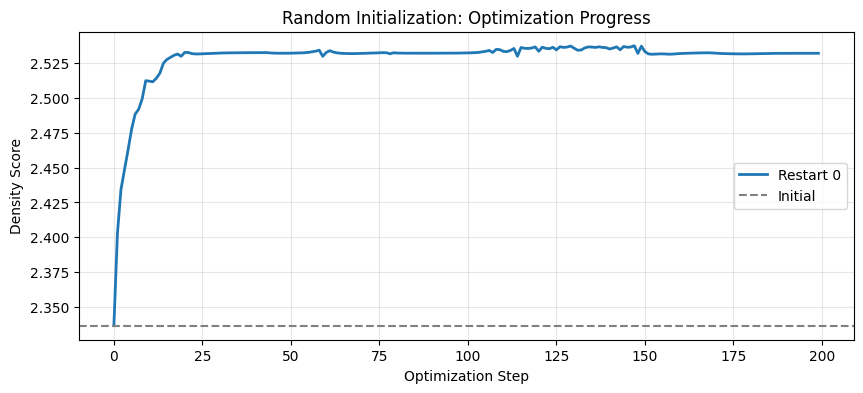

In [4]:
# Optimize from a random starting point
from torch import Tensor

seed_batch = merged[merged.density > 2.0].iloc[:1, :-1]
seed_batch = Tensor(seed_batch.values).to(device)
res_random, details_random = model.optimize_latent(
    task_name="density",
    initial_input=seed_batch,
    mode="max",
    steps=200,
    lr=0.05,
    ae_task_name="reconstruction",
    return_details=True,
)

final_scores = res_random['optimized_score'][0, :, 0].detach().cpu().numpy()
initial_scores = details_random['initial_score'][0, 0].detach().cpu().item()
print("Random Initialization Results:")
print(f"  Initial score: {initial_scores:.4f}")
print(f"  Optimized scores (per restart): {final_scores}")
print(f"  Best improvement: {final_scores.max() - initial_scores:+.4f}")

# Plot optimization trajectory for best restart
best_idx = int(final_scores.argmax())
traj = details_random['trajectory'][0, best_idx, :, 0].detach().cpu().numpy()
plt.figure(figsize=(10, 4))
plt.plot(traj, linewidth=2, label=f'Restart {best_idx}')
plt.axhline(initial_scores, color='gray', linestyle='--', label='Initial')
plt.xlabel('Optimization Step')
plt.ylabel('Density Score')
plt.title('Random Initialization: Optimization Progress')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Strategy 2: Perturbation Around a Known Point

If you have a known good sample, add perturbation to explore the neighborhood.

Baseline sample score: 2.3365
Perturbation 0.00: Score = 2.5079, Improvement vs baseline = +0.1715
Perturbation 0.05: Score = 2.4337, Improvement vs baseline = +0.0972
Perturbation 0.10: Score = 2.4808, Improvement vs baseline = +0.1443
Perturbation 0.20: Score = 2.5195, Improvement vs baseline = +0.1830
Perturbation 0.50: Score = 2.4808, Improvement vs baseline = +0.1443


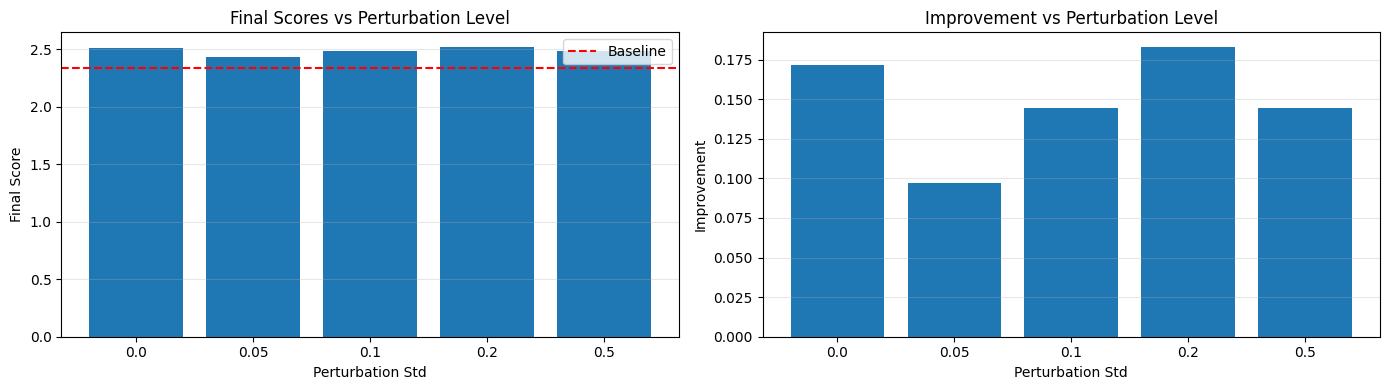

In [5]:
# Create a "known good sample" (from dataset)

with torch.no_grad():
    baseline_score = model(seed_batch)['density'].mean().item()

print(f"Baseline sample score: {baseline_score:.4f}")

perturbation_levels = [0.0, 0.05, 0.1, 0.2, 0.5]
results_perturbation = []

for perturb_std in perturbation_levels:
    res = model.optimize_latent(
        task_name="density",
        initial_input=seed_batch,
        mode="max",
        steps=200,
        perturbation_std=perturb_std,
        ae_task_name="reconstruction",
    )
    final_score = res['optimized_target'][0, 0, 0].item()
    results_perturbation.append({"perturbation": perturb_std, "final_score": final_score})
    print(f"Perturbation {perturb_std:.2f}: Score = {final_score:.4f}, Improvement vs baseline = {final_score - baseline_score:+.4f}")

df_perturb = pd.DataFrame(results_perturbation)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].bar(df_perturb['perturbation'].astype(str), df_perturb['final_score'])
axes[0].axhline(baseline_score, color='red', linestyle='--', label='Baseline')
axes[0].set_xlabel('Perturbation Std')
axes[0].set_ylabel('Final Score')
axes[0].set_title('Final Scores vs Perturbation Level')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(df_perturb['perturbation'].astype(str), df_perturb['final_score'] - baseline_score)
axes[1].axhline(0, color='gray', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Perturbation Std')
axes[1].set_ylabel('Improvement')
axes[1].set_title('Improvement vs Perturbation Level')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Strategy 2: Multi-Restart for Global Search

Try multiple random starts and pick the best result to avoid local optima.

Running optimization with 20 random restarts...
Best score: 2.5577 (restart 16)
Initial score: 2.2646
Statistics across 20 restarts:
  Score range: 2.4771 - 2.5577
  Mean score: 2.5108 ± 0.0208
  Best improvement: 0.2932


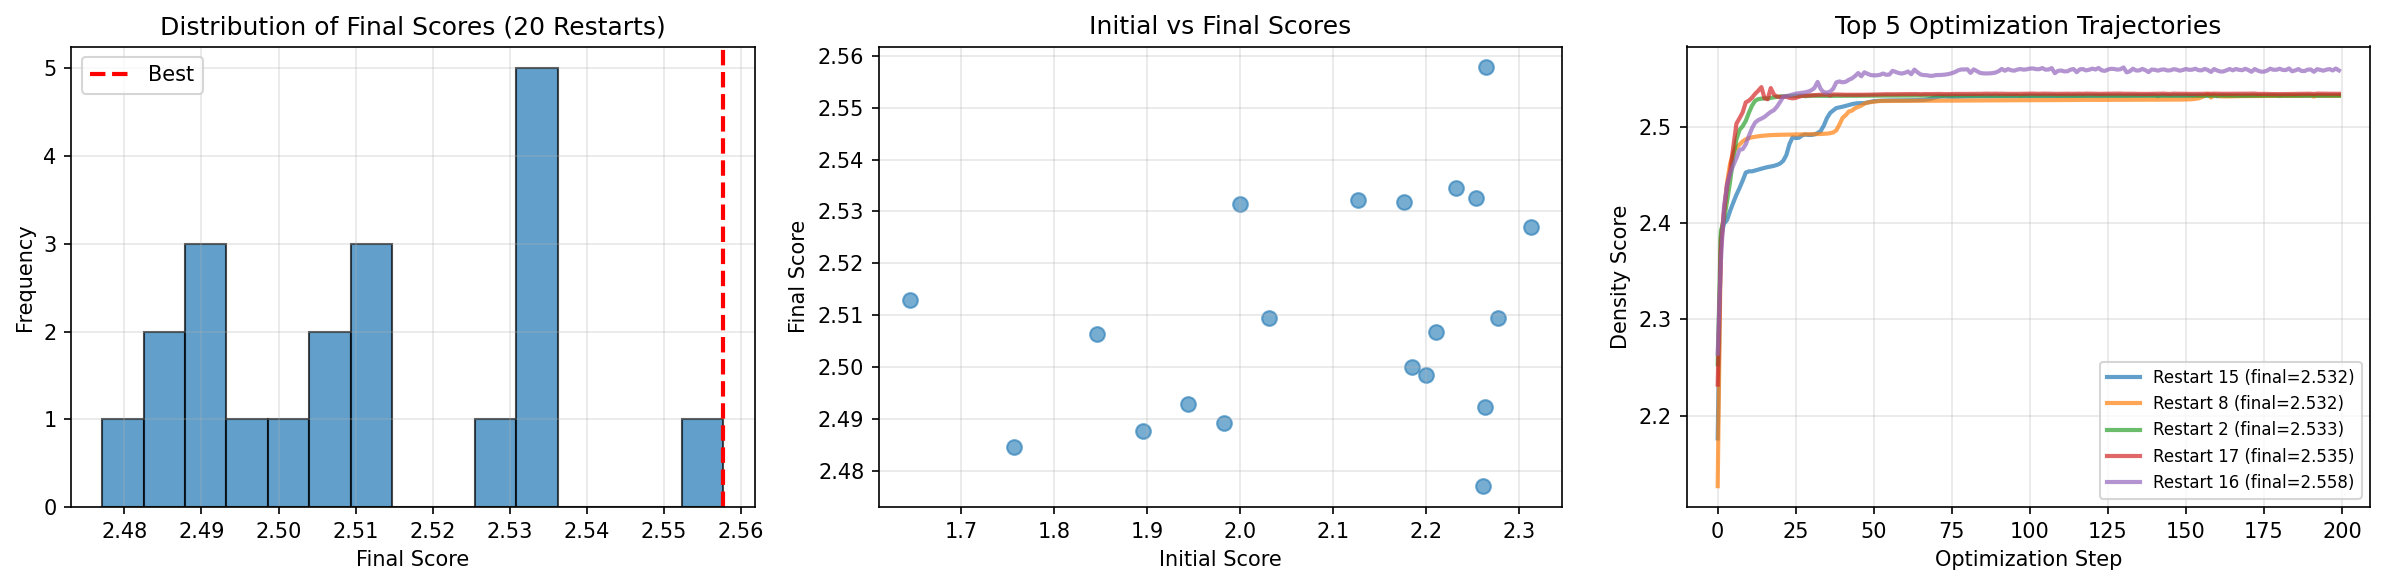

In [6]:
# Global search with multiple restarts
print("Running optimization with 20 random restarts...")

res_multi, details_multi = model.optimize_latent(
    task_name="density",
    initial_input=seed_batch,
    mode="max",
    steps=200,
    lr=0.05,
    num_restarts=20,
    perturbation_std=0.1,
    ae_task_name="reconstruction",
    return_details=True,
)

scores = res_multi['optimized_score'][0, :, 0].detach().cpu().numpy()
initial_val = details_multi['initial_score'][0, :, 0].detach().cpu().numpy()
best_idx = int(scores.argmax())
print(f"Best score: {scores[best_idx]:.4f} (restart {best_idx})")
print(f"Initial score: {initial_val[best_idx]:.4f}")

print(f"Statistics across {len(scores)} restarts:")
print(f"  Score range: {scores.min():.4f} - {scores.max():.4f}")
print(f"  Mean score: {scores.mean():.4f} ± {scores.std():.4f}")
print(f"  Best improvement: {scores.max() - initial_val[best_idx]:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi=150)
axes[0].hist(scores, bins=15, alpha=0.7, edgecolor='black')
axes[0].axvline(scores[best_idx], color='red', linestyle='--', linewidth=2, label='Best')
axes[0].set_xlabel('Final Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Final Scores (20 Restarts)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(initial_val, scores, alpha=0.6, s=50)
axes[1].set_xlabel('Initial Score')
axes[1].set_ylabel('Final Score')
axes[1].set_title('Initial vs Final Scores')
axes[1].grid(alpha=0.3)

traj_multi = details_multi['trajectory'][0, :, :, 0].detach().cpu().numpy()  # (R, steps)
top_5 = np.argsort(scores)[-5:]
for idx in top_5:
    axes[2].plot(traj_multi[idx], alpha=0.7, linewidth=2, label=f"Restart {idx} (final={scores[idx]:.3f})")
axes[2].set_xlabel('Optimization Step')
axes[2].set_ylabel('Density Score')
axes[2].set_title('Top 5 Optimization Trajectories')
axes[2].legend(fontsize=8)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Analyzing the Reconstructed Descriptors

Let's compare the descriptors from different optimization strategies.

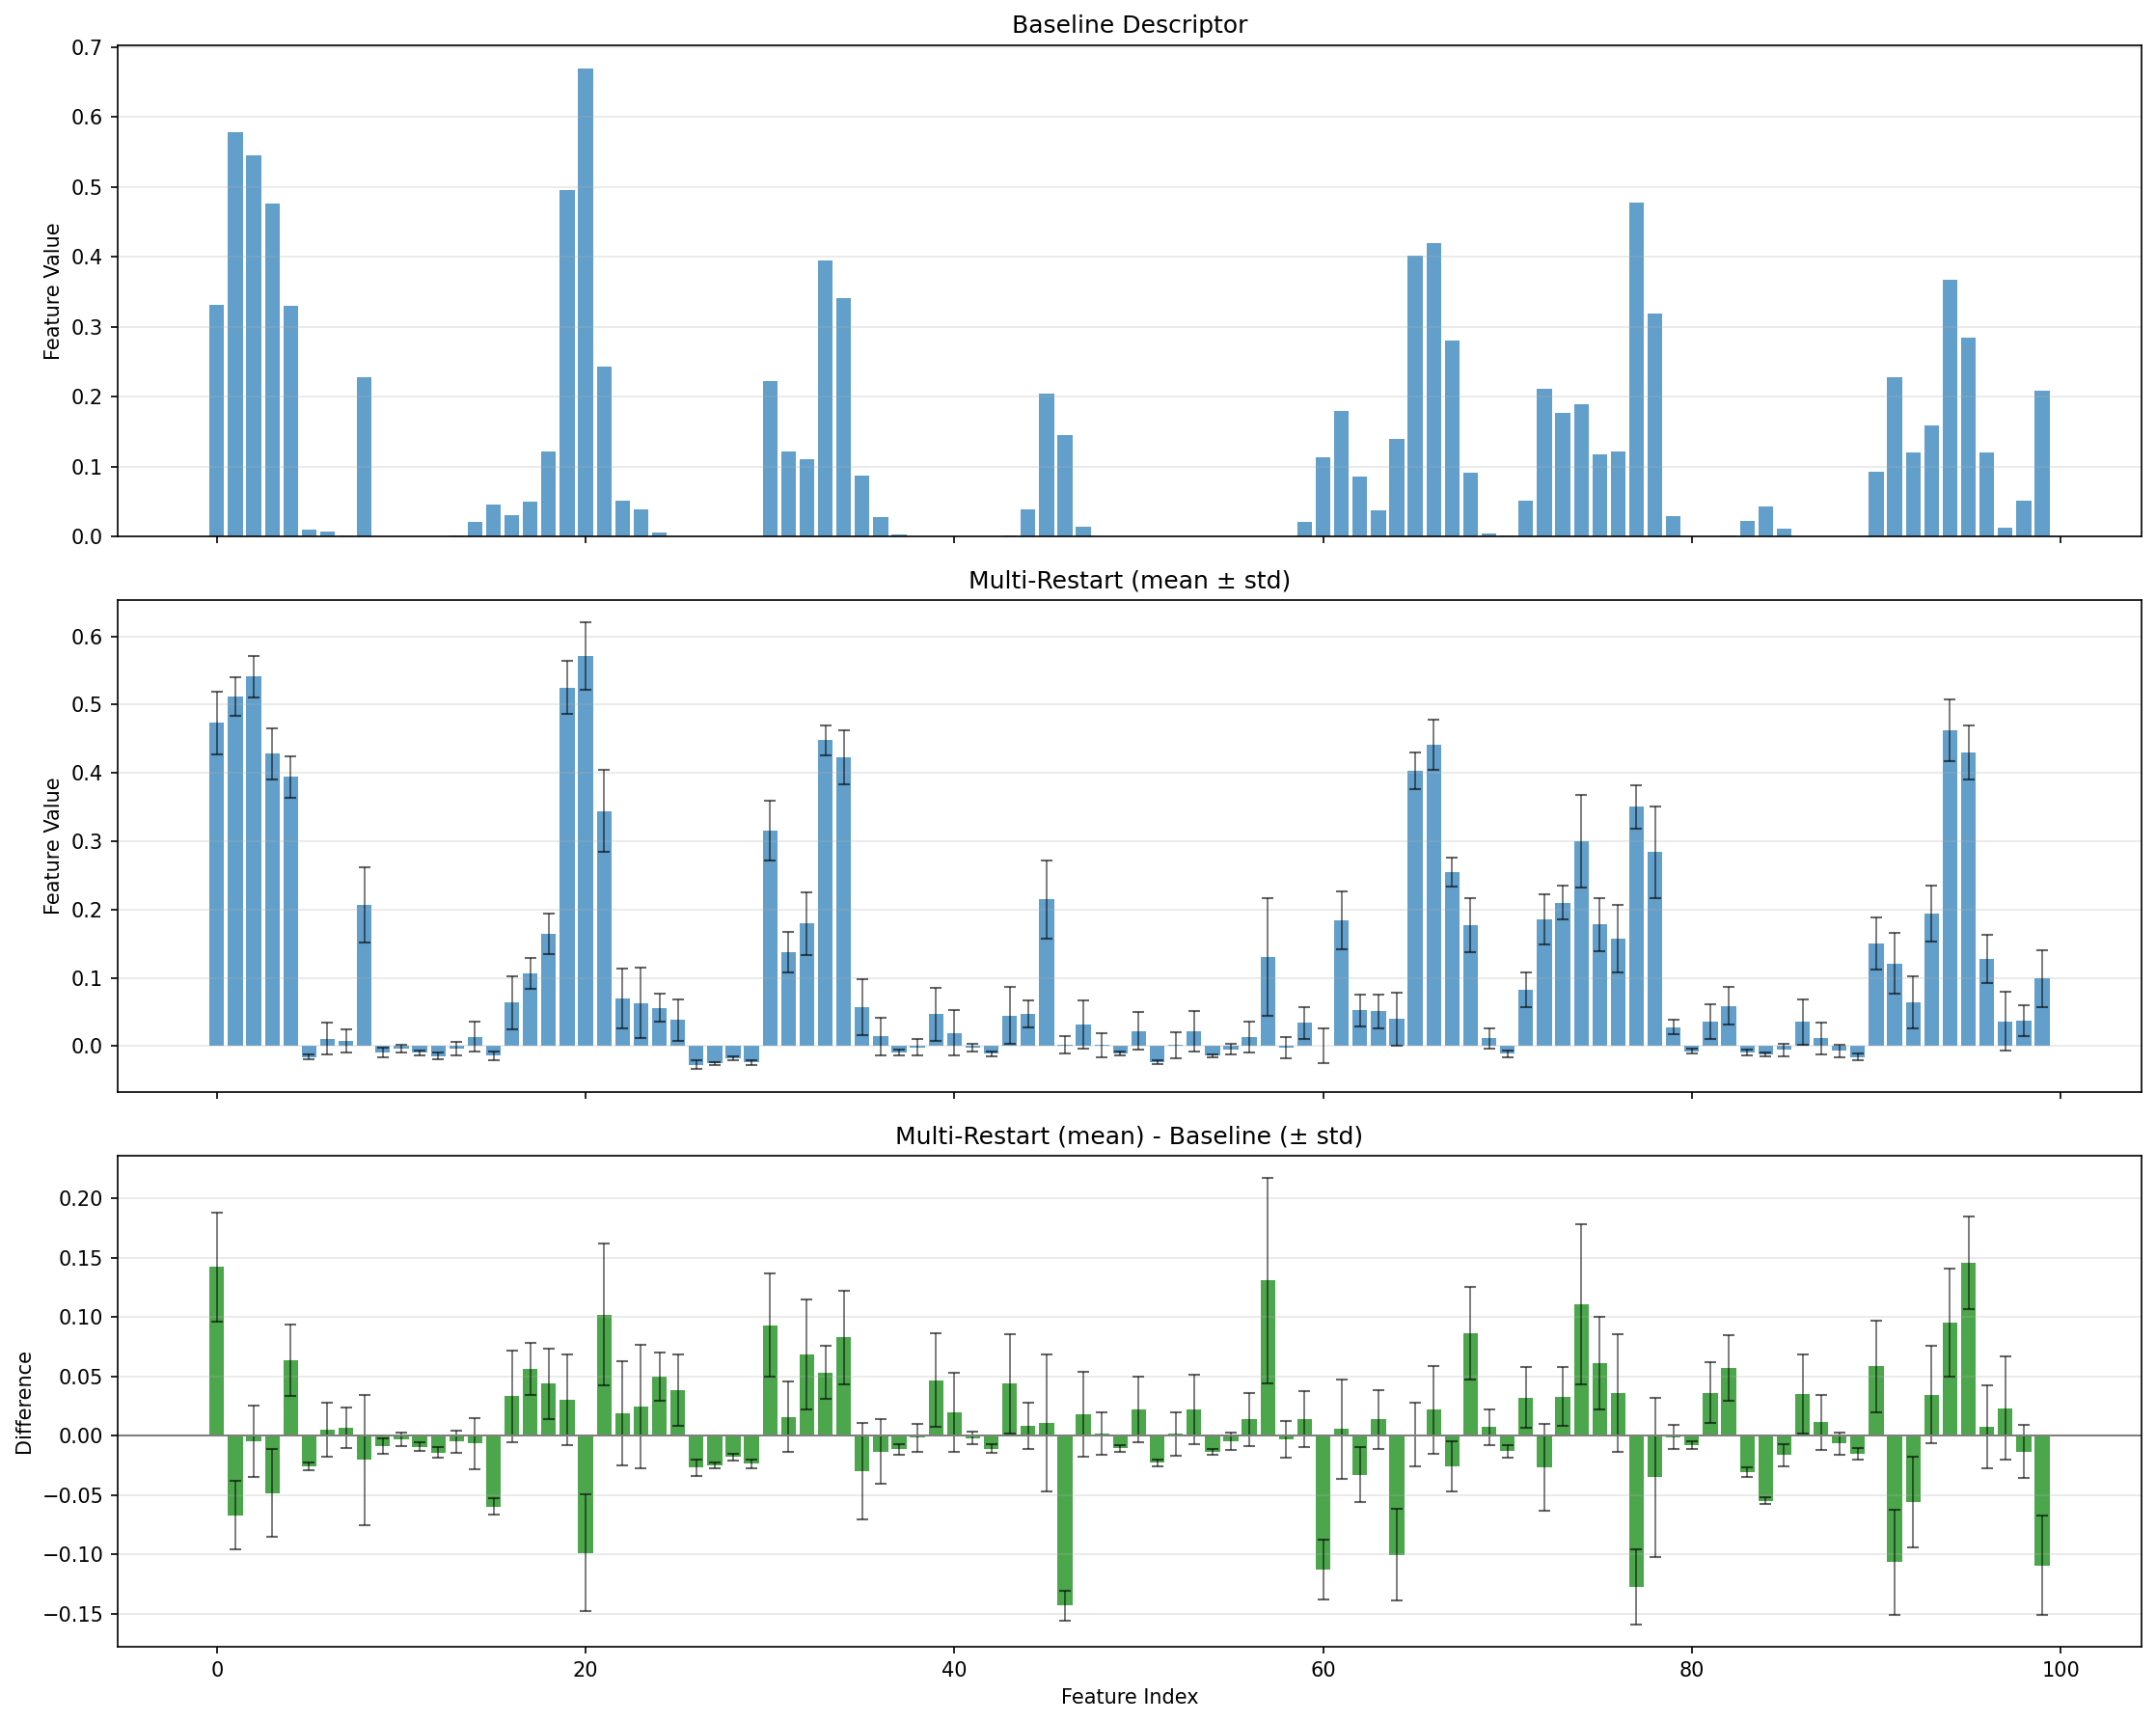

Descriptor statistics (first 50 features):
Baseline:
  Mean: 0.1118
  Std: 0.1558
  Range: [0.0000, 0.6697]
Multi-Restart (mean):
  Mean: 0.1175
  Std: 0.1616
  Range: [-0.0269, 0.5711]
Descriptor statistics (first 50 features):
Baseline:
  Mean: 0.1118
  Std: 0.1558
  Range: [0.0000, 0.6697]
Multi-Restart (mean):
  Mean: 0.1175
  Std: 0.1616
  Range: [-0.0269, 0.5711]


In [7]:
# Get reconstructed/optimized descriptors (pick best restart for each run)
best_multi_idx = int(res_multi['optimized_score'][0, :, 0].argmax())

# Get reconstructed/optimized descriptors from all restarts
all_multi_descriptors = res_multi['optimized_input'][0].cpu().numpy()  # shape: (num_restarts, input_dim)

descriptors_ = {
    'Baseline': seed_batch[0].cpu().numpy().flatten(),
    'Multi-Restart (mean)': all_multi_descriptors.mean(axis=0),
}

# Visualize first n_show features with error bars
n_show = 100
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True, dpi=150)

# Baseline plot
axes[0].bar(range(n_show), descriptors_['Baseline'][:n_show], alpha=0.7)
axes[0].set_ylabel('Feature Value')
axes[0].set_title('Baseline Descriptor')
axes[0].grid(alpha=0.3, axis='y')

# Multi-restart mean with std as error bars
mean_vals = all_multi_descriptors.mean(axis=0)[:n_show]
std_vals = all_multi_descriptors.std(axis=0)[:n_show]
axes[1].bar(range(n_show), mean_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6})
axes[1].set_ylabel('Feature Value')
axes[1].set_title('Multi-Restart (mean ± std)')
axes[1].grid(alpha=0.3, axis='y')

# Difference: Multi-Restart (mean) - Baseline with error bars
diff_vals = mean_vals - descriptors_['Baseline'][:n_show]
axes[2].bar(range(n_show), diff_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6}, color='green')
axes[2].axhline(0, color='gray', linestyle='-', linewidth=1)
axes[2].set_xlabel('Feature Index')
axes[2].set_ylabel('Difference')
axes[2].set_title('Multi-Restart (mean) - Baseline (± std)')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical comparison
print('Descriptor statistics (first 50 features):')
for name, desc in descriptors_.items():
    print(f"{name}:")
    print(f"  Mean: {np.mean(desc[:n_show]):.4f}")
    print(f"  Std: {np.std(desc[:n_show]):.4f}")
    print(f"  Range: [{np.min(desc[:n_show]):.4f}, {np.max(desc[:n_show]):.4f}]")

# Statistical comparison
print('Descriptor statistics (first 50 features):')
for name, desc in descriptors_.items():
    print(f"{name}:")
    print(f"  Mean: {np.mean(desc[:n_show]):.4f}")
    print(f"  Std: {np.std(desc[:n_show]):.4f}")
    print(f"  Range: [{np.min(desc[:n_show]):.4f}, {np.max(desc[:n_show]):.4f}]")
